**Semantic segmentation of historical documents**
=================================================

This notebook aims to show how to use the deep_learning_lab package and how to develop deep neural networks for semantic segmentation of historical documents.

Make sure you applied **Requirements** and **Installation** from the `README.md` by checking below if you activated the `dhs` environment and installed `dh-segment-torch`.  
Expected output:  
`# packages in environment at /home/user/anaconda3/envs/`**`dhs`**`:`  
**`dh-segment-torch`**`          0.1.0                    pypi_0    pypi`

In [1]:
!conda list dh-segment-torch | grep "dhs\|dh-segment-torch"

# packages in environment at /home/21804803t@univ-tours.local/anaconda3/envs/dhs:
dh-segment-torch          0.1.0                    pypi_0    pypi


Training data preparation
=========================

In this part, raw datasets are patched into a unified dataset compatible with the backend framework **dhSegment**.

In [8]:
import os
from deep_learning_lab.data_preparation import Orchestrator, RAW_DATA_DIR, RESULT_DIR

Download datasets
-----------------

Raw datasets can be downloaded in the `raw_datasets/` directory manually or by implementing a script such as `download_data.sh`.
`download_data.sh` is just an example of how to download raw datasets.
It is best to download them manually as they often have different formats.

In [ ]:
"""%%sh
# Automatically
cat download_data.sh
./download_data.sh
"""
# Or Manually

Patch the datasets
------------------

The `Orchestrator` class is the enterpoint to the _**`deep_learning_lab.data_preparation`**_ sub-package.
This tool allows its user to control each step of the patching of the raw datasets.

For the moment, paths and data structures of default datasets are implemented inside the code of the **`deep_learning_lab.data_preparation.Orchestrator`** package.
Therefore, it is necessary to download them in the `raw_datasets/` directory if the add_defaults parameter of `orch.ingestDatasets` is set to True.

In [17]:
print("Default datasets:")
for name, data_dir in Orchestrator.DATASETS.items():
    print(f"- {name.upper()}: {data_dir}")

Default datasets:
- REID: REID2019
- FCR5: FCR_500/data
- BCS_A: Baseline Competition - Simple Documents/ABP_FirstTestCollection
- BCS_B: Baseline Competition - Simple Documents/Bohisto_Bozen_SetP
- BCS_E: Baseline Competition - Simple Documents/EPFL_VTM_FirstTestCollection
- BCS_H: Baseline Competition - Simple Documents/HUB_Berlin_Humboldt
- BCS_N: Baseline Competition - Simple Documents/NAF_FirstTestCollection
- BCS_S: Baseline Competition - Simple Documents/StAM_Marburg_Grimm_SetP
- BCS_U: Baseline Competition - Simple Documents/UCL_Bentham_SetP
- BCS_UN: Baseline Competition - Simple Documents/unibas_e-Manuscripta
- BCC_A: Baseline Competition - Complex Documents/ABP_FirstTestCollection
- BCC_B: Baseline Competition - Complex Documents/Bohisto_Bozen_SetP
- BCC_BH: Baseline Competition - Complex Documents/BHIC_Akten
- BCC_E: Baseline Competition - Complex Documents/EPFL_VTM_FirstTestCollection
- BCC_H: Baseline Competition - Complex Documents/HUB_Berlin_Humboldt
- BCC_N: Baseline C

In [ ]:
sets_labels = [['TextLine'], ['TextRegion'], ['Word'], ['ImageRegion']] # Atomic labels instead of multi-labels are to be promoted

# Create an instance of Orchestrator and specify the output directory structure
orch = Orchestrator(
    output_structure= {'dir_data': "training_data",
                       'dir_images': "images",
                       'dir_labels': "labels"}
)

# Ingest any datasets and add default settings
orch.ingestDatasets(
    datasets= [],
    add_defaults= True
)

# Loop through each set of labels
for set_labels in sets_labels:
    print("Patching for", '_'.join(set_labels))
    
    # Ingest the labels and prompt for additional labels if needed
    orch.ingestLabels(
        uniform_set_labels= set_labels,
        prompt= False
    )
    
    # Validate the labels automatically and suppress verbose output
    orch.validate(
        auto_yes= True,
        verbose= True
    )
    
    # Preprocess the data by resizing images and labels
    orch.preprocess(
        resize= (841, 1188), # To have 1e6 pixels and tensors of same size
        overwrite= False,
        verbose= 2
    )
    print()

Deep learning lab
=================

In this section, deep neural networks can be trained, serialized and used for inference using the **dhSegment** framework in the backend.

In [19]:
import os

from deep_learning_lab.model import Trainer, Predictor

Training
--------

Here, the Trainer train models, tracks logs of metrics in the `tensorboard/log` directory and serialize trained models in `model`.

In [356]:
labels = ['TextLine']

In [357]:
trainer = Trainer(
    labels, # a list of labels for the training data
    input_dir= "training_data", # the directory where the training data is stored
    working_dir= "results", # the directory where results will be saved
    train_ratio= 0.80, # the ratio of data to be used for training
    val_ratio= 0.10, # the ratio of data to be used for validation
    preselected_device= 1 # the index of the GPU device to use for computations (-1 => CPU)
)

**TensorBoard** keeps track of all model metrics during training.

In [ ]:
# Load and run TensorBoard
%load_ext tensorboard

tensorboard_dir = trainer.tensorboard_dir

!echo $tensorboard_dir
#!rm -r $tensorboard_dir & mkdir -p $tensorboard_dir
%tensorboard --logdir $tensorboard_dir

In [ ]:
trainer.train(
    batch_size= 4, # the number of samples to use in each batch during training
    epochs= 100, # the number of epochs to train the model for
    learning_rate= 1e-4, # the rate at which the model adjusts its weights during training
    gamma_exp_lr= 0.9995, # the decay rate for the learning rate during training
    evaluate_every_epoch= 5, # how often to evaluate the model on the validation set during training
    val_patience= 4, # how many epochs to wait for improvement in validation loss before early stopping
    repeat_dataset= 4, # how many times to repeat the training data during each epoch
    output_size= 1e6 # the size of the images
)

Inference
---------

Here, the predictor use the model for inference on new images (in this case from `training_data/test.csv`), save the vignettes of elements of content in the `predictions/` directory and output all its results.

In [359]:
labels = ['TextLine']

In [360]:
predictor = Predictor(
    labels, # a list of labels for the predicted classes
    input_dir= 'inference_data', # the directory containing the input images to predict on
    output_dir= 'predictions', # the directory to save the predicted images to (if None, saves to 'predictions')
    working_dir= "results", # the directory where results will be saved
    output_size= None, # the size of the predicted images (if None, uses input image size)
    from_csv= os.path.join('training_data', 'test.csv'), # is the path to a CSV file with input image paths and labels
    reset_from_csv= True, # whether to reset the input before starting the predictor
    preselected_device= 1 # the index of the GPU device to use for computations (-1 => CPU)
)

results = predictor.start(
    batch_size= 4, # the number of images to process at once
    drawRegions= True, # whether to draw regions on the images
    cutVignettes= True, # whether to cut out vignettes from the images
    bounding_box= False, # whether to use a bounding box or a polygon around the predicted regions
    verbose= True # whether to print status messages
)

  0%|          | 0/37 [00:00<?, ?it/s]

Post-processing predictions : 100%|██████████| 146/146 [01:17<00:00,  1.89it/s]


Tests
=====

Let's see the results. The model has saved all the vignettes in the `predictions` directory.

In [361]:
from PIL import Image
import matplotlib.pyplot as plt
import os

In [362]:
assert len(results)

print("Content of results data:")
for key, value in results[0].items():
    print(f"- {key}: {type(value)}")
print("Number of 'probasMaps' (1 'Background' + n classes):", len(results[0]['probasMaps']))

Content of results data:
- probas: <class 'numpy.ndarray'>
- path: <class 'str'>
- name: <class 'str'>
- probasMaps: <class 'list'>
- labels: <class 'numpy.ndarray'>
- image: <class 'numpy.ndarray'>
- regions: <class 'numpy.ndarray'>
- vignettes: <class 'list'>
Number of 'probasMaps' (1 'Background' + n classes): 2


In [387]:
image_nb = 7
predictions = results[image_nb]

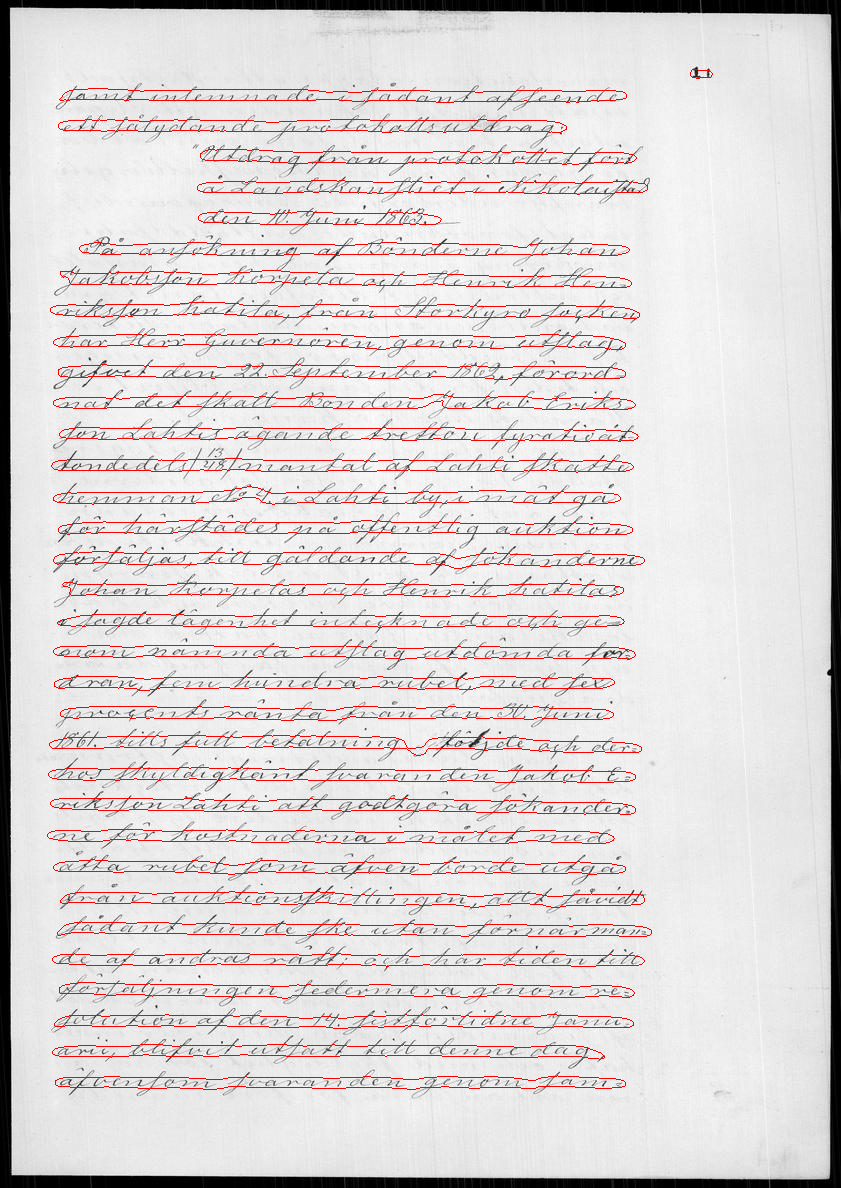

In [388]:
# Show the regions found on the original image
Image.fromarray(predictions['regions'])

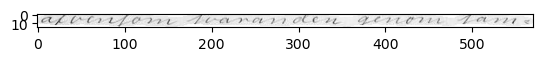

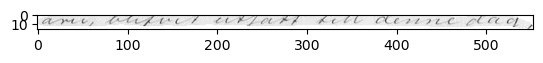

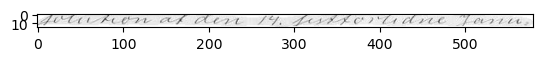

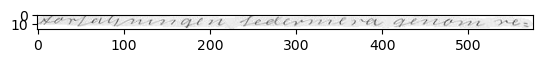

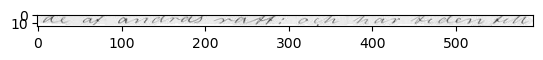

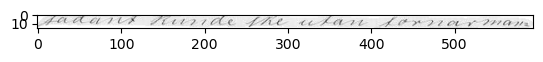

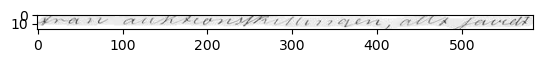

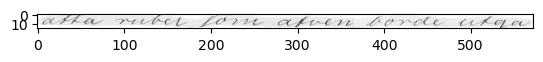

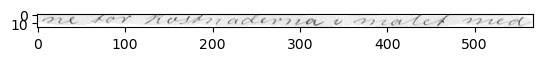

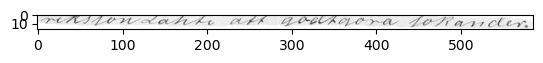

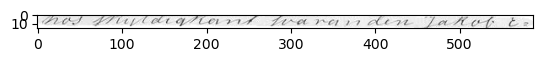

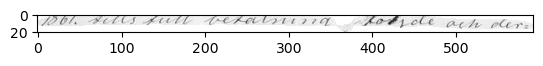

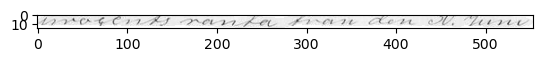

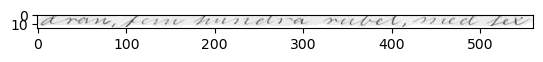

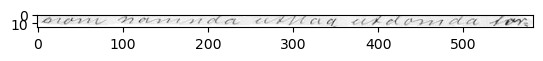

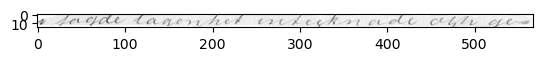

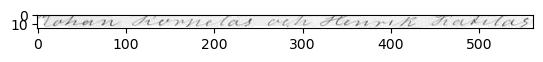

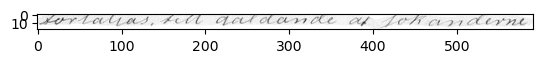

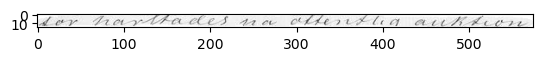

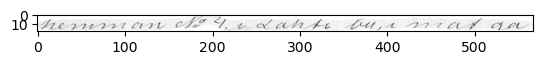

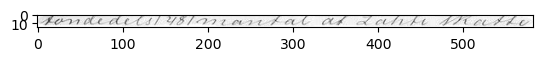

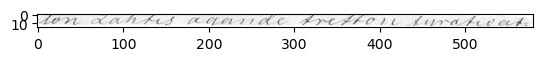

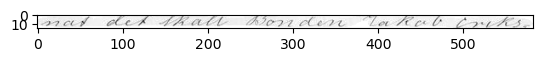

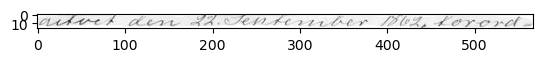

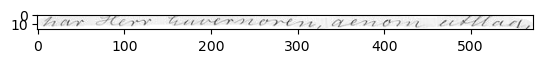

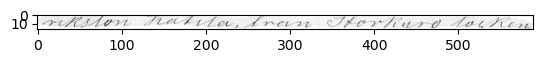

In [389]:
# Show the regions found
for it, vignette in enumerate(predictions['vignettes']):
    plt.imshow(Image.fromarray(vignette))
    plt.show()
    if it == 25: break # Limit the output